In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import csv
import pylab
import scipy.cluster.hierarchy as sch
from sourmash.logging import notify

In [2]:
# download the genbank 
!curl -L https://osf.io/cbhgd/download -o bacteria_genbank_lineages.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   459  100   459    0     0   1157      0 --:--:-- --:--:-- --:--:--  1159
100 83.1M  100 83.1M    0     0  18.9M      0  0:00:04  0:00:04 --:--:-- 24.5M  0  0:00:10  0:00:01  0:00:09 16.8M


In [3]:
# generate abundance matrix from samples
!sourmash tax summarize outputs/gather/demo_gather_x_genbank_k31.csv outputs/gather/HSMA33MX_gather_x_genbank_k31.csv \
   --output-format lineage_summary -o demo \
   -r species -t bacteria_genbank_lineages.csv


== This is sourmash version 4.1.1.dev84+g7044ae5. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

loaded 6 gather results.
of 6, missed 2 lineage assignments.
The following are missing from the taxonomy information: GCA_002754635,GCA_000256725
loaded 6 gather results.
of 6, missed 2 lineage assignments.
The following are missing from the taxonomy information: GCA_002754635,GCA_000256725


In [4]:
def read_lineage_sample_frac(filename, full_lineage=False):
    with open(filename) as fp:
        reader = csv.reader(fp, delimiter = "\t")
        sample_names =  next(reader)
        sample_names = sample_names[1:] # remove "lineage" from sample vector
        num_cols = len(fp.readline().split("\t"))
        #num_samples = len(sample_names)
        fp.seek(0)
        abund = np.genfromtxt(fp, delimiter='\t', skip_header = 1, usecols = np.arange(1, num_cols))
        abund = np.around(abund, decimals=3)
        notify(f'loading abundance of {num_cols-1} samples in lineage summary from file {filename}...')
        #notify('...got {} x {} matrix.', *abund)
    
    # get lineages
    with open(filename) as fp:
        lineages = [row.split("\t")[0] for row in fp]
        lineages = lineages[1:]

    if not full_lineage:
        lineages = [lineage.split(";")[-1] for lineage in lineages]
    
    return abund, sample_names, lineages

In [5]:
abund_filename = "demo.lineage_summary.tsv"


In [6]:
abundances, samples, lineages = read_lineage_sample_frac(abund_filename, full_lineage=False)

loading abundance of 2 samples in lineage summary from file demo.lineage_summary.tsv...


In [7]:
print("abundances: ", abundances)
print("sample names: ", samples)
print("lineages: ", lineages)

abundances:  [[0.016 0.016]
 [0.057 0.057]
 [0.058 0.058]]
sample names:  ['demo', 'HSMA33MX']
lineages:  ['Bacteroides vulgatus', 'Prevotella copri', 'Escherichia coli']


In [8]:
from sourmash.fig import plot_composite_matrix

In [9]:
def plot_2d_matrix_and_dendrogram(D, xlabels, ylabels):
    # hierarchically cluster the lineages axis
    Y = sch.linkage(D, method='single')  # centroid
    Z1 = sch.dendrogram(Y, orientation='left', labels=ylabels,
                        get_leaves=True)

    # re-order labels along rows, top to bottom
    idx1 = Z1['leaves']
    reordered_ylabels = [ ylabels[i] for i in idx1 ]

    # reorder abund by the clustering in the dendrogram
    D = D[idx1, :]

    #xstart = 0.315
    xstart = 0.45
    width = 0.45
    scale_xstart = xstart + width + 0.01

    fig, ax = plt.subplots()
    im = ax.imshow(D, origin = "lower")

    # Show all ticks
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_yticks(np.arange(len(reordered_ylabels)))
    # Label ticks with the respective list entries
    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(reordered_ylabels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(reordered_ylabels)):
        for j in range(len(xlabels)):
            text = ax.text(j, i, D[i, j],
                           ha="center", va="center", color="w")

    # Plot colorbar.
    axcolor = fig.add_axes([scale_xstart, 0.25, 0.02, 0.6])
    pylab.colorbar(im, cax=axcolor)
    # set title
    ax.set_title("Fractional abundances of gather results")

    return fig, xlabels, reordered_ylabels, D


(<Figure size 432x288 with 2 Axes>,
 ['demo', 'HSMA33MX'],
 ['Bacteroides vulgatus', 'Prevotella copri', 'Escherichia coli'],
 array([[0.016, 0.016],
        [0.057, 0.057],
        [0.058, 0.058]]))

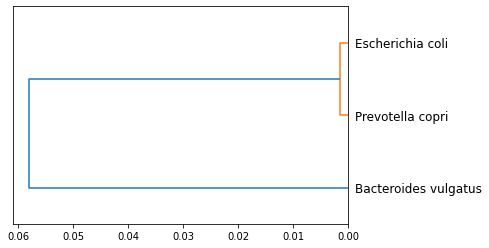

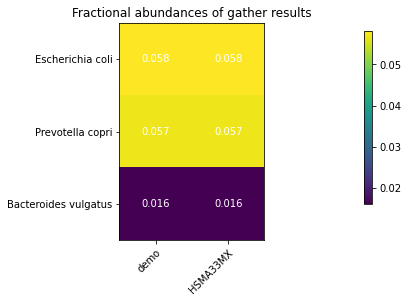

In [10]:
plot_2d_matrix_and_dendrogram(abundances, samples, lineages)

In [11]:
def plot_lineages(lineage_abundances):
    # read lineages file to numpy matrix and labels
    abundances, samples, lineages = read_lineage_sample_frac(lineage_abundances, full_lineage=False)
    # make the dendrogram+matrix:
    (fig, xlabels, ylabels, matrix2d) =  plot_2d_matrix_and_dendrogram(abundances, samples, lineages)
    #fig.savefig(matrix_out)
    #notify(f'wrote numpy distance matrix to: {matrix_out}')
    fig.tight_layout()
    plt.show()
    
    # write out re-ordered matrix and labels
    #if args.csv:
    #    with FileOutputCSV(args.csv) as csv_fp:
    #        w = csv.writer(csv_fp)
    #        w.writerow(rlabels)

    #        for i in range(len(rlabels)):
    #            y = []
    #            for j in range(len(rlabels)):
    #                y.append('{}'.format(rmat[i][j]))
    #            w.writerow(y)
    #    notify('Wrote clustered matrix and labels out to {}', args.csv)

loading abundance of 2 samples in lineage summary from file demo.lineage_summary.tsv...
<ipython-input-11-bd69db603fee>:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


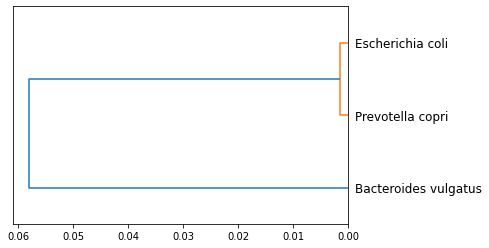

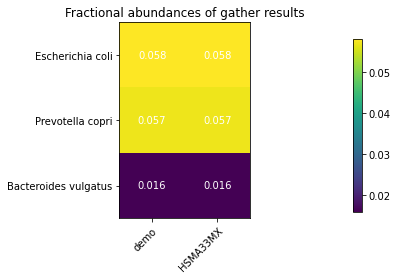

In [12]:
plot_lineages(abund_filename)

In [13]:
!ls outputs/tax

HSMA33MX_gather_x_gtdbrs202_genbank_euks_k31.krona.tsv
HSMA33MX_gather_x_gtdbrs202_genbank_euks_k31.krona.txt
HSMA33MX_gather_x_gtdbrs202_genbank_euks_k31.with-lineages.csv
taxdemo.lineage_summary.tsv


loading abundance of 3 samples in lineage summary from file outputs/tax/taxdemo.lineage_summary.tsv...
<ipython-input-11-bd69db603fee>:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


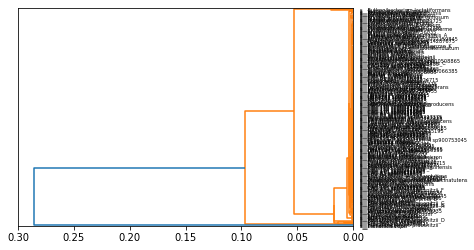

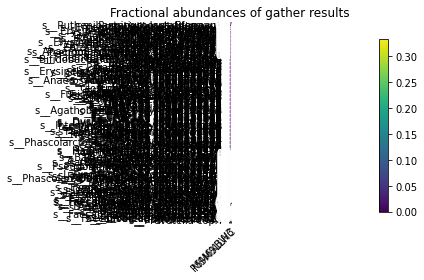

In [14]:
larger_filename = "outputs/tax/taxdemo.lineage_summary.tsv"
plot_lineages(larger_filename)